In [1]:
import torch
import torch.nn as nn
from torch.func import grad as funcgrad

import matplotlib.pyplot as plt

In [2]:
@torch.enable_grad()
def autograd(f, x, create_graph=True, do_sum=False):

    x.requires_grad_(True)
    
    return torch.autograd.grad(
        f(x).sum() if do_sum else f(x), 
        x, 
        create_graph=create_graph
    )[0]

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        i, h, o = 1, 16, 1
        self.mlp = nn.Sequential(
            nn.Linear(i, h), 
            nn.LayerNorm(h), 
            nn.SiLU(), 
            nn.Linear(h, h), 
            nn.LayerNorm(h), 
            nn.SiLU(), 
            nn.Linear(h, o)
        )

    def forward(self, x):
        return self.mlp(x).squeeze()

# Raw Model

In [4]:
f = MLP()

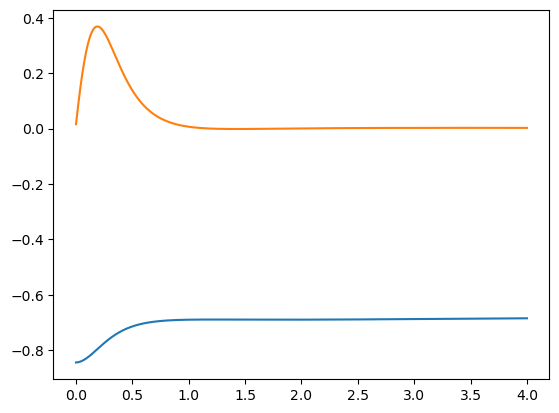

In [5]:
x = torch.linspace(0, 4, 1000).unsqueeze(1)
plt.plot(x, f(x).detach())
plt.plot(x, torch.vmap(funcgrad(f))(x).detach())

# Objective

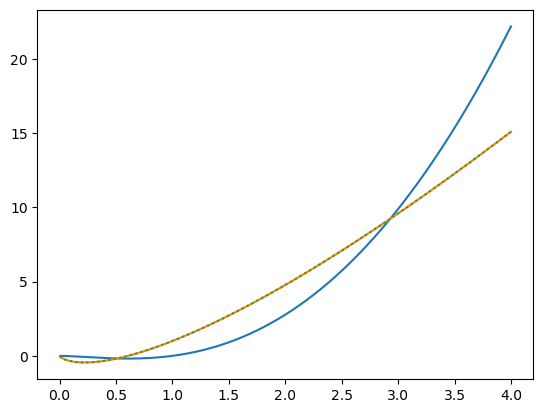

In [6]:
g = lambda x : (x ** 2 * torch.log(x)).squeeze()
dgdx = lambda x : 2 * x * torch.log(x) + x
plt.plot(x, g(x).detach())
plt.plot(x, dgdx(x).detach())
plt.plot(x, torch.vmap(funcgrad(g), )(x), linestyle='dotted')

# Train

In [7]:
optimizer = torch.optim.Adam(f.parameters())
losses = []

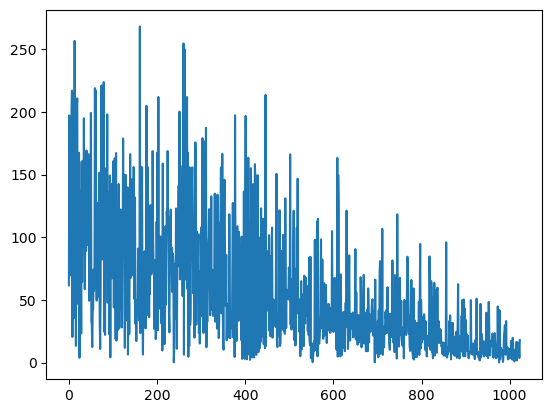

In [8]:
for epoch in range(1024):
    optimizer.zero_grad()
    
    x = torch.rand(4, 1) * 5

    dg = dgdx(x)
    dg += torch.randn_like(dg) * 0.1

    dg_hat = torch.vmap(funcgrad(f))(x)

    loss = torch.mean((dg - dg_hat) ** 2)
    loss.backward()
    optimizer.step()
    
    losses.append(float(loss))
    
plt.plot(losses)

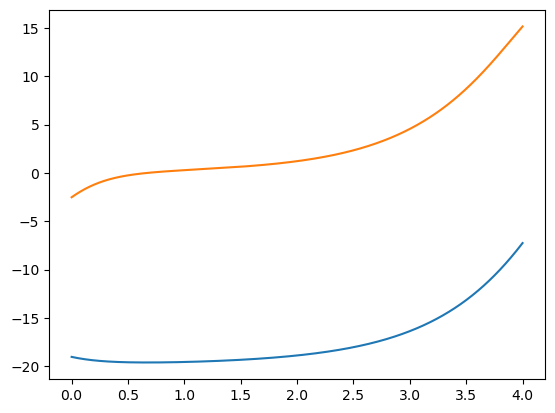

In [9]:
x = torch.linspace(0, 4, 1000).unsqueeze(1)
plt.plot(x, f(x).detach())
plt.plot(x, torch.vmap(funcgrad(f))(x).detach())